# Sara och Marcus Uppgift 1

# 3.1 Kontinuerlig optimering

# 3.2 TSP datainsamling och preprocessing

In [112]:
from sko.ACA import ACA_TSP
from math import sin, asin, cos, sqrt, atan2, radians
import regex as re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import numpy as np
import matplotlib.pyplot as plt


def get_data():
    # Scrapes the data 
    options = webdriver.ChromeOptions()
    options.add_argument("headless")
    driver = webdriver.Chrome('./chromedriver', options = options)

    driver.get("https://www.infoplease.com/world/geography/major-cities-latitude-longitude-and-corresponding-time-zones")
    elem = driver.find_element_by_id("A0001770")
    text = elem.text
    driver.close()
    return text

def get_cities(data: str):
    # Formats the data into a more convenient lookup table
    rows = data.split('\n')
    cities = []
    for row in rows[2:]:
        city = re.findall('[A-Za-z]*, [A-Za-z]*', row)
        print(city)
        latitude, longitude = re.findall('[0-9]{1,} [0-9]{1,} [SNWE]', row)
        cities.append({'city': city, 
                       'latitude': latitude, 
                       'longitude': longitude})
    return cities

def to_degrees(city):
    # Converts the lat and long coordinates to decimal degrees, returns them in radians
    dms_to_deg = lambda deg, minutes, direction: (float(deg) + float(minutes)/60) * (-1 if direction in ['W', 'S'] else 1)
    
    latitude = city['latitude']
    longitude = city['longitude']

    lat = dms_to_deg(*re.split('[ ]', latitude))
    long = dms_to_deg(*re.split('[ ]', longitude))

    return radians(lat), radians(long)

def calc_d(city1, city2):
    # calculates the distance between two coordinates
    lat1, lon1 = to_degrees(city1)
    lat2, lon2 = to_degrees(city2)
    
    R = 6372.8 # km

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = (sin(dlat/2)**2) + (cos(lat1) * cos(lat2) * (sin(dlon/2)**2))
    c = 2 * asin(sqrt(a)) 
    
    distance = R * c
    return distance # km

def get_distance_matrix(cities):
    # Generates a distance matrix from a list of cities with coordinates
    index_matrix = [[(i, j) for j in range(len(cities))] for i in range(len(cities))]
    distance_matrix = [[calc_d(cities[i_tup[0]], cities[i_tup[1]]) for i_tup in row] for row in index_matrix]
    return np.array([np.array(row) for row in distance_matrix])

def cal_total_distance(routine) -> float:
    # Calculates the total distance of a given routine
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])

# 3.3 Baseline 1

In [ ]:
data = get_data()
cities = get_cities(data)
distance_matrix = get_distance_matrix(cities)

In [7]:
routines = [np.array([i for i in range(120)]) for j in range(100000)]
for routine in routines:
    np.random.shuffle(routine)

distances = [cal_total_distance(routine) for routine in routines]

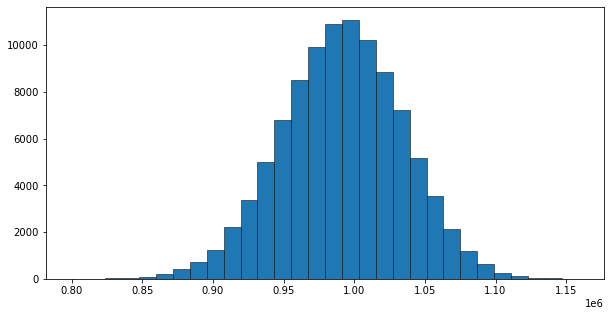

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(distances, bins = 30, edgecolor='black', linewidth=0.5)
plt.show()

# 3.4 Baseline 2

# 3.5 Baseline 3

In [117]:
def GA(setting: list):
    max_iter = setting[0]
    prob_mut = setting[1]
    size_pop = setting[2]

    ga_tsp = GA_TSP(func=cal_total_distance, n_dim=120, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut)
    best_points, best_distance = ga_tsp.run()
    return best_points, best_distance

In [145]:
import multiprocess
import time
import itertools
from sko.GA import GA_TSP


def run(setting: list):

    max_iter, prob_mut, pop_size = setting[0], setting[1], setting[2]
        
    n_cores = multiprocessing.cpu_count()
    
    start_mp = time.time()
    
    pool = multiprocessing.Pool(processes = n_cores)
    ncore_settings = [setting for i in range(n_cores)]
    result = pool.map(GA, ncore_settings)
    
    best_mp = ()
    
    end_mp = time.time()

    start_seq = time.time()
    
    best_seq = None

    for i in range(n_cores):
        best_x, best_y = GA(setting)
        if best_seq == None:
            best_seq = (best_x, best_y)
        if best_y < best_seq[1]:
            best_seq = (best_x, best_y)
    
    end_seq = time.time()
    
    mp_time = end_mp-start_mp
    seq_time = end_seq-start_seq
    
    best_mp = best_seq
    
    print(f'\nPopulation size: {pop_size}\n\nMax iterations: {max_iter} \n\nMutation probability: {prob_mut}\n\n---\n\nBest with running sequentially: \nRoutine: {list(best_seq[0])} - Distance: {round(int(best_seq[1]))}km\n\nBest with multiprocessing:\nRoutine: {list(best_mp[0])} - Distance: {round(int(best_mp[1]))}km\n')
    #print(f'With multiprocessing ({n_cores} cores) finished in {round(mp_time, 2)} seconds\n')
    #print(f'Without multiprocessing finished in {round(seq_time, 2)} seconds\n')
    print('-'*30)
    

In [ ]:
data = get_data()
cities = get_cities(data)
distance_matrix = get_distance_matrix(cities)

In [146]:
all_settings = list(itertools.product([100, 500, 1000], [0.001, 0.01, 0.05]))
all_settings = list(map(list, all_settings))
all_settings = [setting + [40] for setting in all_settings]

for setting in all_settings:
    run(setting)


Population size: 40

Max iterations: 100 

Mutation probability: 0.001

---

Best with running sequentially: 
Routine: [79, 10, 54, 44, 27, 45, 49, 31, 50, 74, 98, 108, 51, 8, 96, 56, 17, 93, 77, 106, 78, 26, 99, 55, 104, 32, 48, 19, 81, 72, 113, 59, 80, 34, 36, 57, 101, 76, 25, 46, 83, 115, 86, 23, 47, 14, 84, 39, 105, 82, 33, 111, 9, 61, 21, 22, 117, 6, 37, 92, 52, 102, 110, 38, 43, 90, 100, 114, 89, 30, 53, 73, 28, 87, 4, 118, 20, 103, 60, 11, 71, 2, 95, 67, 62, 68, 18, 12, 16, 5, 63, 66, 119, 13, 40, 35, 7, 69, 112, 0, 91, 85, 1, 109, 65, 64, 88, 3, 116, 97, 75, 42, 70, 24, 15, 94, 29, 107, 41, 58] - Distance: 647451km

Best with multiprocessing:
Routine: [79, 10, 54, 44, 27, 45, 49, 31, 50, 74, 98, 108, 51, 8, 96, 56, 17, 93, 77, 106, 78, 26, 99, 55, 104, 32, 48, 19, 81, 72, 113, 59, 80, 34, 36, 57, 101, 76, 25, 46, 83, 115, 86, 23, 47, 14, 84, 39, 105, 82, 33, 111, 9, 61, 21, 22, 117, 6, 37, 92, 52, 102, 110, 38, 43, 90, 100, 114, 89, 30, 53, 73, 28, 87, 4, 118, 20, 103, 60, 11,

Process SpawnPoolWorker-220:
Traceback (most recent call last):
  File "/Users/marcuseriksson/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/marcuseriksson/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/marcuseriksson/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/marcuseriksson/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/Users/marcuseriksson/opt/anaconda3/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


KeyboardInterrupt: 

# 3.6 Ant Colony Optimization

In [17]:
data = get_data()
cities = get_cities(data)
distance_matrix = get_distance_matrix(cities)

In [ ]:
num_points = len(cities)
size_pop = 50
max_iters = [100, 250, 500]

for max_iter in max_iters:
    start = time.time()
    aca = ACA_TSP(func=cal_total_distance, 
                  n_dim=num_points,
                  size_pop=size_pop, max_iter=max_iter,
                  distance_matrix=distance_matrix)

    best_x, best_y = aca.run()
    stop = time.time()

    time_elapsed = stop-start
    print(f'\nRoutine: {best_x}\n\nDistance: {round(best_y)}km\n\nTime: {round(time_elapsed/60, 2)} min\n\nPopulation size: {size_pop}\n\nMax iterations: {max_iter}\n')
    print('-'*20)